In [1]:
from datasets import load_dataset
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict
import math


c:\Users\zerok\miniconda3\envs\EI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset

In [2]:
train_dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split='train')
test_dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split='test')
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)
df = pd.concat([train_df, test_df], ignore_index=True)
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [3]:
# Save the initial DataFrame to a CSV file
df.to_csv('../data/raw/sentiment_data.csv', index=False)


In [4]:

# Load the DataFrame back from the CSV if needed (optional since you already have dfReddit loaded)
df = pd.read_csv('../data/raw/sentiment_data.csv')


In [5]:
train_df

,id,text,label,sentiment
30839,1081,Call me when you have time and a good phone ...,1,neutral
34577,27030,Belated kay Tita. Wow! 2 prizes in a day! Co...,2,positive
34432,15943,watching on SNL,1,neutral
24761,2064,2.5 years here & left Dell OKC for the last ti...,2,positive
7577,22712,haha! nice! Have fun doll! Hopefully I`ll see...,2,positive
...,...,...,...,...
29094,9476,I use to love this app. It is the perfect orga...,0,negative
26128,8736,"The Ads now pop-up full screen. That is very, ...",0,negative
13330,7169,Usefull,2,positive
574,2905,The application consistantly tells me I have n...,1,neutral


In [6]:
df['text'] = df['text'].fillna('')
test_df['text'] = test_df['text'].fillna('')
train_df['text'] = train_df['text'].fillna('')

In [7]:
test_df


,id,text,label,sentiment
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
9,793,sad face.,0,negative
16,7922,You`re welcome...,2,positive
18,9289,Early monday cramming... yay. Only a few weeks...,1,neutral
55,16200,"Years ago, my brother saw you and Bruce walki...",2,positive
...,...,...,...,...
36403,16840,Loving the # dreambears on #britains got talent,2,positive
36404,9655,"It was great before, but lately it sends notif...",0,negative
36421,779,I used this app many years ago but I can't rem...,2,positive
36423,1309,If it had reminders in free version it would h...,1,neutral


In [8]:

# Save the training and testing DataFrames to CSV files
train_df.to_csv('../data/clean/train.csv', index=False)
test_df.to_csv('../data/clean/test.csv', index=False)


In [9]:

# Optionally, reload them to verify everything worked as expected
train_df = pd.read_csv('../data/clean/train.csv')
test_df = pd.read_csv('../data/clean/test.csv')

In [10]:

def load_sentiment_scores(file_path):
    """
    Load sentiment scores from a file into a dictionary.
    """
    sentiment_scores = {}
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) != 2:
                continue
            word, score = parts
            sentiment_scores[word] = int(score)
    return sentiment_scores

# Load sentiment scores
sentiment_scores = load_sentiment_scores('sentiment_dict.txt')


In [11]:
def calculate_ratios(data):
    """
    Calculate the ratio of positive, negative, and neutral comments in the dataset.
    """
    total_reviews = len(data)
    if total_reviews == 0:
        return 0, 0, 0
    pos_count = len(data[data['sentiment'] == 'positive'])
    neg_count = len(data[data['sentiment'] == 'negative'])
    neu_count = len(data[data['sentiment'] == 'neutral'])

    pos_ratio = pos_count / total_reviews
    neg_ratio = neg_count / total_reviews
    neu_ratio = neu_count / total_reviews

    return pos_ratio, neg_ratio, neu_ratio

# Calculate ratios for the combined dataset
pos_ratio, neg_ratio, neu_ratio = calculate_ratios(df)

In [12]:

def split_data_by_sentiment(data, sentiment):
    return data[data['sentiment'] == sentiment]['text'].tolist()

# Split the data into positive and negative comments
positive_reviews = split_data_by_sentiment(train_df, 'positive')
negative_reviews = split_data_by_sentiment(train_df, 'negative')
neutral_reviews = split_data_by_sentiment(train_df, 'neutral')


In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zerok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
from nltk.tokenize import word_tokenize
negation_words = {"not", "no", "never", "n't", "cannot", "do not", "does not", "no", "not", "don't", "hardly", "cannot", "shouldn’t", "doesnt", "lack", "daren’t", "wasn’t", "didnt", "lacking", "don’t", "wouldn’t", "hadnt", "lacks", "doesn’t", "weren’t", "hasn’t", "neither", "didn’t", "won’t", "havn’t", "nor", "hadn’t", "without", "haven’t"}
punctuation_marks = set(string.punctuation)
stemmer = PorterStemmer()

def preprocess_reviews(review):
    if review is None or not isinstance(review, str):
        review = str(review)
    
    review = review.lower()
    tokens = word_tokenize(review)
    
    negated = False
    processed_tokens = []
    for token in tokens:
        if token in punctuation_marks:
            negated = False
            continue 
        if token in negation_words:
            negated = True
            continue
        elif negated:
            token = "NOT_" + token
            negated = False

        processed_tokens.append(token)

    return ' '.join(processed_tokens)

def calculate_word_counts_with_incremental_weighting(comments, sentiments, sentiment_scores):
    """
    Calculate word counts from a list of comments, incrementing counts based on sentiment scores
    for words that match the sentiment context of the comment.
    """
    word_counts = {}
    for comment, sentiment in zip(comments, sentiments):
        tokens = preprocess_reviews(comment).split()
        for token in tokens:
            # Initialize or increment the base count
            word_counts[token] = word_counts.get(token, 0) + 1

            # Check if the token is in the sentiment scores dictionary
            if token in sentiment_scores:
                score = sentiment_scores[token]
                # Check if the sentiment of the score aligns with the sentiment of the comment
                if (score > 0 and sentiment == 'positive') or (score < 0 and sentiment == 'negative'):
                    # Increment by the absolute value of the score
                    word_counts[token] += abs(score)
    return word_counts

# Calculate total word counts with sentiment weighting
total_weighted_positive_words = calculate_word_counts_with_incremental_weighting(positive_reviews, ['positive'] * len(positive_reviews), sentiment_scores)
total_weighted_negative_words = calculate_word_counts_with_incremental_weighting(negative_reviews, ['negative'] * len(negative_reviews), sentiment_scores)
total_weighted_neutral_words = calculate_word_counts_with_incremental_weighting(neutral_reviews, ['neutral'] * len(neutral_reviews), sentiment_scores)



In [14]:

total_positive_words = sum(total_weighted_positive_words.values())
total_negative_words = sum(total_weighted_negative_words.values())
total_neutral_words = sum(total_weighted_neutral_words.values())

In [15]:

# Vocabulary and smoothing parameter
vocabulary = set(total_weighted_positive_words.keys()).union(total_weighted_negative_words.keys()).union(total_weighted_neutral_words.keys())
N_vocabulary = len(vocabulary)
alpha = 1  # Laplacian smoothing factor

# Initialize parameters dictionaries
parameters_positive = {}
parameters_negative = {}
parameters_neutral = {}

# Calculate parameters for each word in the vocabulary with Laplacian smoothing
for word in vocabulary:
    # For positive sentiment
    n_word_given_positive = total_weighted_positive_words.get(word, 0)
    p_word_given_positive = (n_word_given_positive + alpha) / (total_positive_words + alpha * N_vocabulary)
    parameters_positive[word] = p_word_given_positive

    # For negative sentiment
    n_word_given_negative = total_weighted_negative_words.get(word, 0)
    p_word_given_negative = (n_word_given_negative + alpha) / (total_negative_words + alpha * N_vocabulary)
    parameters_negative[word] = p_word_given_negative

    # For neutral sentiment
    n_word_given_neutral = total_weighted_neutral_words.get(word, 0)
    p_word_given_neutral = (n_word_given_neutral + alpha) / (total_neutral_words + alpha * N_vocabulary)
    parameters_neutral[word] = p_word_given_neutral


#negation_words = ["not", "no", "never", "n't", "cannot", "do not", "does not", "no", 
                  #"not", "don't", "hardly", "cannot", "shouldn’t", "doesnt", "lack", "daren’t", 
                  #"wasn’t", "didnt", "lacking", "don’t", "wouldn’t", "hadnt", "lacks", "doesn’t", 
                  #"weren’t", "hasn’t", "neither", "didn’t", "won’t", "havn’t", "nor", "hadn’t", "without", "haven’t"]
#def contains_negation(message_tokens):
    #""" Check if the tokenized message contains any negation words, considering potential modifications. """
    #processed_negation_words = [neg_word.replace(" ", "_") for neg_word in negation_words]
    #return any(word in processed_negation_words for word in message_tokens)


import re

def classify(message, parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio):
    """
    Classify the message based on the learned parameters and given ratios.
    Adjust sentiment polarity if negations are detected.
    """
    message = re.sub('[^\w\s]', ' ', message)
    #words = message.lower().split()
    words = preprocess_reviews(message)
    
    log_p_positive = math.log(pos_ratio)
    log_p_negative = math.log(neg_ratio)
    log_p_neutral = math.log(neu_ratio)

    #negation_present = contains_negation(words)

    for word in words.lower().split():
        if word in parameters_positive:
            log_p_positive += math.log(parameters_positive[word])
        if word in parameters_negative:
            log_p_negative += math.log(parameters_negative[word])
        if word in parameters_neutral:
            log_p_neutral += math.log(parameters_neutral[word])

    # if negation_present:
    #     log_p_positive, log_p_negative = log_p_negative, log_p_positive  # Swapping log probabilities of positive and negative

    # Determine the label based on the highest log probability
    if log_p_positive > log_p_negative and log_p_positive > log_p_neutral:
        return 'positive'
    elif log_p_negative > log_p_positive and log_p_negative > log_p_neutral:
        return 'negative'
    else:
        return 'neutral'

# The rest of your script should work fine after this change


In [16]:
# save model to a file
import pickle

with open('../src/model_Bayes/bayes.pkl', 'wb') as file:
    pickle.dump((parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio), file)

In [17]:
# load model from a file
with open('../src/model_Bayes/bayes.pkl', 'rb') as file:
    parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio = pickle.load(file)

In [18]:
import re
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report


def predict_sentiments(df, parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio):
    predictions = []
    for index, row in df.iterrows():
        predicted_label = classify(row['text'], parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio)
        predictions.append(predicted_label)
    return predictions

# Apply the classification to the test dataset
test_df['predicted_sentiment'] = predict_sentiments(test_df, parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio)

# Calculate accuracy
actual_labels = test_df['sentiment']
predicted_labels = test_df['predicted_sentiment']
accuracy = accuracy_score(actual_labels, predicted_labels)

# Display the accuracy
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(actual_labels, predicted_labels))

Accuracy: 0.64
              precision    recall  f1-score   support

    negative       0.72      0.52      0.61      2141
     neutral       0.53      0.75      0.62      2654
    positive       0.78      0.62      0.69      2493

    accuracy                           0.64      7288
   macro avg       0.68      0.63      0.64      7288
weighted avg       0.67      0.64      0.64      7288



In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

In [23]:
# Initialize a tokenizer with a maximum vocabulary size
train_df = train_df.dropna(subset=['text']).astype({'text': str})
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])


# Convert the text data to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Pad the sequences to ensure equal length input sequences
train_padded = pad_sequences(train_sequences, padding='post', maxlen=100)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=100)

In [24]:

model = Sequential([
    Embedding(input_dim=5000, output_dim=64),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model with an Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint('../src/model_LSTM/lstm.keras', monitor='val_accuracy', save_best_only=True, save_weights_only=False)

In [25]:
# labels positive 2, negative 0, neutral 1
train_sentiment = tf.keras.utils.to_categorical(train_df['label'])
test_sentiment = tf.keras.utils.to_categorical(test_df['label'])
history = model.fit(train_padded, train_sentiment,
                    batch_size=32, # Adjust batch size
                    epochs=5, # Increase epochs
                    validation_data=(test_padded, test_sentiment),
                    callbacks=[checkpoint])


Epoch 1/5
911/911 ━━━━━━━━━━━━━━━━━━━━ 95s 93ms/step - accuracy: 0.5310 - loss: 0.9309 - val_accuracy: 0.6965 - val_loss: 0.7139
Epoch 2/5
911/911 ━━━━━━━━━━━━━━━━━━━━ 134s 83ms/step - accuracy: 0.7235 - loss: 0.6487 - val_accuracy: 0.6936 - val_loss: 0.7053
Epoch 3/5
911/911 ━━━━━━━━━━━━━━━━━━━━ 94s 96ms/step - accuracy: 0.7680 - loss: 0.5701 - val_accuracy: 0.6990 - val_loss: 0.7081
Epoch 4/5
911/911 ━━━━━━━━━━━━━━━━━━━━ 144s 98ms/step - accuracy: 0.7937 - loss: 0.5039 - val_accuracy: 0.6922 - val_loss: 0.7431
Epoch 5/5
911/911 ━━━━━━━━━━━━━━━━━━━━ 154s 111ms/step - accuracy: 0.8205 - loss: 0.4520 - val_accuracy: 0.6974 - val_loss: 0.8166


In [33]:
# save model to a file
model.save('../src/model_LSTM/lstm.keras')


In [34]:
# Load the model
model = tf.keras.models.load_model('../src/model_LSTM/lstm.h5')

KeyError: "Unable to synchronously open object (object 'embedding' doesn't exist)"

In [35]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_padded, test_sentiment)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.6931 - loss: 0.8347
Loss: 0.8166
Accuracy: 0.6974


In [36]:
# function to predict sentiment and 
def predict_sentiment_LSTM(model, tokenizer, text):
    """
    Predict the sentiment of the given text using the trained model.
    """
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=100)
    prediction = model.predict(padded_sequence)

    # Determine the sentiment based on the highest probability
    if prediction[0][2] > prediction[0][0] and prediction[0][2] > prediction[0][1]:
        return 'positive'
    elif prediction[0][0] > prediction[0][2] and prediction[0][0] > prediction[0][1]:
        return 'negative'
    else:
        return 'neutral'

In [114]:
# Test the function with a sample text
text = "I love this product!"
prediction = predict_sentiment_LSTM(model, tokenizer, text)
print(prediction)

1/1 [==============================] - 0s 467ms/step
positive


In [37]:
# Apply the classification to the test dataset
test_df['predicted_sentiment_bayes'] = predict_sentiments(test_df, parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio)
test_df['predicted_sentiment_LSTM'] = [predict_sentiment_LSTM(model, tokenizer, text) for text in test_df['text']]
# Calculate accuracy
actual_labels = test_df['sentiment']
predicted_labels_bayes = test_df['predicted_sentiment_bayes']
predicted_labels_LSTM = test_df['predicted_sentiment_LSTM']
accuracy_bayes = accuracy_score(actual_labels, predicted_labels_bayes)
accuracy_LSTM = accuracy_score(actual_labels, predicted_labels_LSTM)

# Display the accuracy
print(f'Accuracy Bayes: {accuracy_bayes:.2f}')
print(f'Accuracy LSTM: {accuracy_LSTM:.2f}')
print(classification_report(actual_labels, predicted_labels_bayes))
print(classification_report(actual_labels, predicted_labels_LSTM))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━

In [38]:

# get the distribution of the test data
test_df['sentiment'].value_counts()

# get the distribution of the results given by the two models
test_df['predicted_sentiment_bayes'].value_counts()
test_df['predicted_sentiment_LSTM'].value_counts()



predicted_sentiment_LSTM
neutral     2728
positive    2716
negative    1844
Name: count, dtype: int64

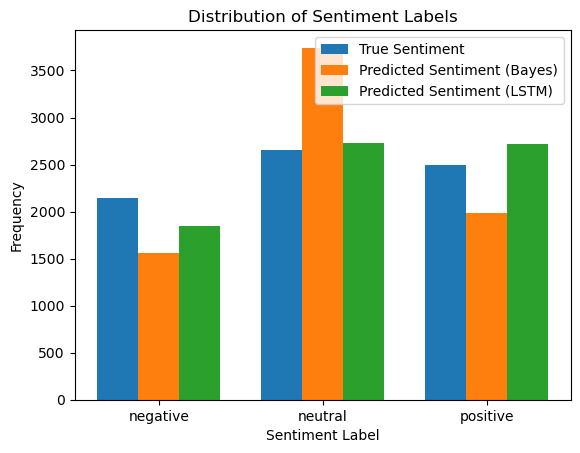

In [39]:
import numpy as np
import matplotlib.pyplot as plt

true_counts = test_df['sentiment'].value_counts().sort_index()
bayes_counts = test_df['predicted_sentiment_bayes'].value_counts().sort_index()
lstm_counts = test_df['predicted_sentiment_LSTM'].value_counts().sort_index()

labels = np.arange(len(true_counts))

bar_width = 0.25

plt.bar(labels - bar_width, true_counts, width=bar_width, label='True Sentiment')
plt.bar(labels, bayes_counts, width=bar_width, label='Predicted Sentiment (Bayes)')
plt.bar(labels + bar_width, lstm_counts, width=bar_width, label='Predicted Sentiment (LSTM)')

plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.xticks(labels, true_counts.index)

plt.legend()

plt.show()


In [40]:
# Calculate the correct counts for each sentiment label
bayes_correct_counts = test_df[test_df['predicted_sentiment_bayes'] == test_df['sentiment']]['predicted_sentiment_bayes'].value_counts().sort_index()
lstm_correct_counts = test_df[test_df['predicted_sentiment_LSTM'] == test_df['sentiment']]['predicted_sentiment_LSTM'].value_counts().sort_index()
# Calculate the total counts for each sentiment label
bayes_total_counts = test_df['predicted_sentiment_bayes'].value_counts().sort_index()
lstm_total_counts = test_df['predicted_sentiment_LSTM'].value_counts().sort_index()

# Calculate the accuracy for each model
bayes_accuracy = bayes_correct_counts / bayes_total_counts
lstm_accuracy = lstm_correct_counts / lstm_total_counts

print("Bayes Model Accuracy:")
print(bayes_accuracy)

print("\nLSTM Model Accuracy:")
print(lstm_accuracy)


Bayes Model Accuracy:
predicted_sentiment_bayes
negative    0.717949
neutral     0.530999
positive    0.776435
Name: count, dtype: float64

LSTM Model Accuracy:
predicted_sentiment_LSTM
negative    0.734816
neutral     0.627933
positive    0.741900
Name: count, dtype: float64


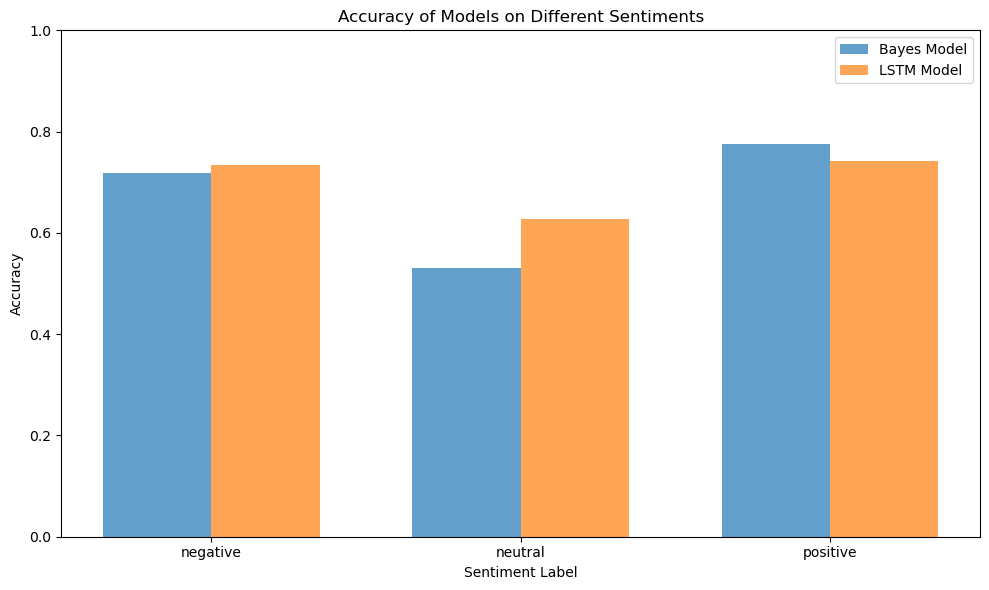

In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sentiments = bayes_accuracy.index

labels = np.arange(len(sentiments))

bar_width = 0.35

plt.bar(labels - bar_width/2, bayes_accuracy, width=bar_width, label='Bayes Model', alpha=0.7)
plt.bar(labels + bar_width/2, lstm_accuracy, width=bar_width, label='LSTM Model', alpha=0.7)

plt.xlabel('Sentiment Label')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models on Different Sentiments')
plt.xticks(labels, sentiments)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()
